### Import

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import os
import shutil

### Define Directories

In [2]:
# Define directories
dataset_path = "/kaggle/input/lungs-disease-dataset-4-types/Lung Disease Dataset"
train_dir = f"{dataset_path}/train"
val_dir = f"{dataset_path}/val"
test_dir = f"{dataset_path}/test"

### Create folds directories

In [3]:
# Use the writable directory in Kaggle
folds_dir = "folds"
os.makedirs(folds_dir, exist_ok=True)

# Define number of folds (3 folds for training + 1 fold for validation)
num_folds = 3

# Function to split the dataset into folds and copy validation data to fold_3
def create_folds(src_dir, val_dir, folds_dir, num_folds):
    # For each class, split images into 3 folds
    for class_name in os.listdir(src_dir):
        class_dir = os.path.join(src_dir, class_name)
        
        if os.path.isdir(class_dir):
            # List all image files in the class directory
            image_files = os.listdir(class_dir)
            image_paths = [os.path.join(class_dir, file) for file in image_files]
            
            # Generate stratified splits (train split for each fold)
            skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
            labels = [class_name] * len(image_paths)  # All images in the same class share the same label
            
            # Create a fold directory for the class
            for fold in range(num_folds):
                fold_class_dir = os.path.join(folds_dir, f"fold_{fold}", class_name)
                os.makedirs(fold_class_dir, exist_ok=True)
            
            # Create fold_3 directory for validation set
            fold_3_class_dir = os.path.join(folds_dir, "fold_3", class_name)
            os.makedirs(fold_3_class_dir, exist_ok=True)
            
            for fold, (train_idx, _) in enumerate(skf.split(image_paths, labels)):  # Only use train_idx
                # Split image paths into training subsets for the fold
                train_images = [image_paths[i] for i in train_idx]
                
                # Move images to the fold directories
                for img in train_images:
                    shutil.copy(img, os.path.join(folds_dir, f"fold_{fold}", class_name, os.path.basename(img)))
            
            # Copy validation images from val_dir into fold_3
            val_class_dir = os.path.join(val_dir, class_name)
            if os.path.isdir(val_class_dir):
                val_images = os.listdir(val_class_dir)
                for val_img in val_images:
                    shutil.copy(os.path.join(val_class_dir, val_img), os.path.join(folds_dir, "fold_3", class_name, val_img))

# Create folds for the train directory and copy validation data to fold_3
create_folds(train_dir, val_dir, folds_dir, num_folds)

print("Train data split into 3 folds and validation data moved to fold_3.")


Train data split into 3 folds and validation data moved to fold_3.


### Data Preprocessing and Augmentation

In [4]:
# Image size and batch size
image_size = (224, 224)
batch_size = 32

# Define transformations
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4876, 0.4976, 0.5008], std=[0.2203, 0.2228, 0.2241])
])


valid_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4876, 0.4976, 0.5008], std=[0.2203, 0.2228, 0.2241])
])



### Model Architecture

In [5]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Convolutional Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(negative_slope=0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(16 * 28 * 28, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.3)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(0.3)
        )

        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

# Instantiate model
model = CNN(num_classes=5)

### Training Setup

In [6]:
# Hyperparameters and settings
learning_rate = 0.001
num_epochs = 50

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler_ReduceLROnPlateau = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            if self.verbose:
                print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model...")
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(val_loss, model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print("✅ CUDA is available. Using GPU.")
else:
    print("⚠️ CUDA is not available. Using CPU instead.")
    
model.to(device)


✅ CUDA is available. Using GPU.


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=12544

### Training Function

In [7]:
def train_model(model, train_loader, val_loader, num_epochs=num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0.0
    best_model_state = None  # To store the best model's state dict

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        scheduler_ReduceLROnPlateau.step(val_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

        # Save model if validation accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()  # Save best model's state

        # Early stopping
        early_stopping(val_loss / len(val_loader), model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Return metrics and best model's state
    return train_losses, val_losses, train_accuracies, val_accuracies, best_model_state, best_val_acc



### Cross Validation

In [8]:
import os
from torch.utils.data import DataLoader, ConcatDataset
import torch.optim as optim

# Define paths to the folds directory
folds_dir = "folds"
num_folds = 4

# Initialize the best validation accuracy to a very low value
best_val_acc = 0.0
best_fold = -1  # To store the fold number of the best model

# Collecting results for each fold
fold_train_losses, fold_val_losses = [], []
fold_train_accuracies, fold_val_accuracies = [], []
overall_best_model_state = None  # Store the best model state across all folds

for fold in range(num_folds):
    print(f"\nTraining fold {fold+1}/{num_folds}")
    
    # Create training and validation datasets for this fold
    train_folds = [f"fold_{i}" for i in range(num_folds) if i != fold]  # Exclude the current fold
    val_fold = f"fold_{fold}"  # Current fold as validation

    # Combine the training folds
    train_datasets = [
        datasets.ImageFolder(os.path.join(folds_dir, train_fold), transform=train_transform)
        for train_fold in train_folds
    ]
    train_dataset = ConcatDataset(train_datasets)  # Combine training datasets
    val_dataset = datasets.ImageFolder(os.path.join(folds_dir, val_fold), transform=valid_transform)

    # Create DataLoaders for current fold
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Reinitialize model, optimizer, scheduler, and early stopping for each fold
    model = CNN(num_classes=5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    early_stopping = EarlyStopping(patience=10, verbose=True)

    # Train the model for the current fold and get the best model's state and accuracy
    train_losses, val_losses, train_accuracies, val_accuracies, fold_best_model_state, fold_best_val_acc = train_model(
        model, train_loader, val_loader
    )

    # Store results for each fold
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

    # Check if this fold's best model is the overall best
    if fold_best_val_acc > best_val_acc:
        best_val_acc = fold_best_val_acc
        overall_best_model_state = fold_best_model_state
        best_fold = fold

# Load the best model for testing
model.load_state_dict(overall_best_model_state)

print(f"Cross-validation completed. Best model loaded from fold {best_fold + 1} with validation accuracy: {best_val_acc:.2f}%")




Training fold 1/4
Epoch [1/50], Train Loss: 0.7898, Train Acc: 68.14%, Val Loss: 0.6552, Val Acc: 72.83%
Validation loss decreased (inf --> 0.655152). Saving model...
Epoch [2/50], Train Loss: 0.6518, Train Acc: 72.80%, Val Loss: 0.5223, Val Acc: 78.98%
Validation loss decreased (0.655152 --> 0.522323). Saving model...
Epoch [3/50], Train Loss: 0.6019, Train Acc: 75.30%, Val Loss: 0.5081, Val Acc: 78.33%
Validation loss decreased (0.522323 --> 0.508138). Saving model...
Epoch [4/50], Train Loss: 0.5682, Train Acc: 76.40%, Val Loss: 0.5232, Val Acc: 77.05%
EarlyStopping counter: 1 out of 10
Epoch [5/50], Train Loss: 0.5541, Train Acc: 77.23%, Val Loss: 0.4127, Val Acc: 82.33%
Validation loss decreased (0.508138 --> 0.412678). Saving model...
Epoch [6/50], Train Loss: 0.5267, Train Acc: 78.14%, Val Loss: 0.4199, Val Acc: 81.83%
EarlyStopping counter: 1 out of 10
Epoch [7/50], Train Loss: 0.5126, Train Acc: 78.38%, Val Loss: 0.3942, Val Acc: 84.38%
Validation loss decreased (0.412678 -->

### Average Metric

In [9]:
import numpy as np

def plot_accuracy_table(fold_train_accuracies, fold_val_accuracies, fold_train_losses, fold_val_losses):
    num_folds = len(fold_train_accuracies)
    
    # Create a table of accuracies and losses for each fold
    table_data = []
    avg_train_accuracy = 0
    avg_val_accuracy = 0
    avg_train_loss = 0
    avg_val_loss = 0
    
    for fold in range(num_folds):
        # Find the epoch with the lowest validation loss
        best_epoch = np.argmin(fold_val_losses[fold])
        
        # Retrieve the accuracy and loss at that epoch
        train_accuracy_at_best_loss = fold_train_accuracies[fold][best_epoch] if len(fold_train_accuracies[fold]) > 0 else 0
        val_accuracy_at_best_loss = fold_val_accuracies[fold][best_epoch] if len(fold_val_accuracies[fold]) > 0 else 0
        train_loss_at_best_loss = fold_train_losses[fold][best_epoch] if len(fold_train_losses[fold]) > 0 else 0
        val_loss_at_best_loss = fold_val_losses[fold][best_epoch] if len(fold_val_losses[fold]) > 0 else 0
        
        # Add each fold's data to the table
        table_data.append([f"Fold {fold + 1}", 
                          f"{train_accuracy_at_best_loss:.2f}%", 
                          f"{val_accuracy_at_best_loss:.2f}%",
                          f"{train_loss_at_best_loss:.4f}",
                          f"{val_loss_at_best_loss:.4f}"])
        
        # Update averages
        avg_train_accuracy += train_accuracy_at_best_loss
        avg_val_accuracy += val_accuracy_at_best_loss
        avg_train_loss += train_loss_at_best_loss
        avg_val_loss += val_loss_at_best_loss

    # Calculate averages
    avg_train_accuracy /= num_folds
    avg_val_accuracy /= num_folds
    avg_train_loss /= num_folds
    avg_val_loss /= num_folds

    # Add header row
    table_data.insert(0, ["Fold", "Train Accuracy (%)", "Validation Accuracy (%)", "Train Loss", "Validation Loss"])

    # Output the table in lines
    for row in table_data:
        print("\t".join(row))
    
    # Print averages
    print("\nAverage:")
    print(f"Average Train Accuracy: {avg_train_accuracy:.2f}%")
    print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}%")
    print(f"Average Train Loss: {avg_train_loss:.4f}")
    print(f"Average Validation Loss: {avg_val_loss:.4f}\n")

# Example usage:
# Assuming fold_train_accuracies, fold_val_accuracies, fold_train_losses, and fold_val_losses are already defined
plot_accuracy_table(fold_train_accuracies, fold_val_accuracies, fold_train_losses, fold_val_losses)



Fold	Train Accuracy (%)	Validation Accuracy (%)	Train Loss	Validation Loss
Fold 1	86.51%	89.71%	0.3213	0.2411
Fold 2	85.14%	89.22%	0.3382	0.2556
Fold 3	86.40%	88.76%	0.3274	0.2501
Fold 4	85.36%	86.16%	0.3404	0.3473

Average:
Average Train Accuracy: 85.85%
Average Validation Accuracy: 88.46%
Average Train Loss: 0.3318
Average Validation Loss: 0.2735



### Plotting Training and Validation Metrics

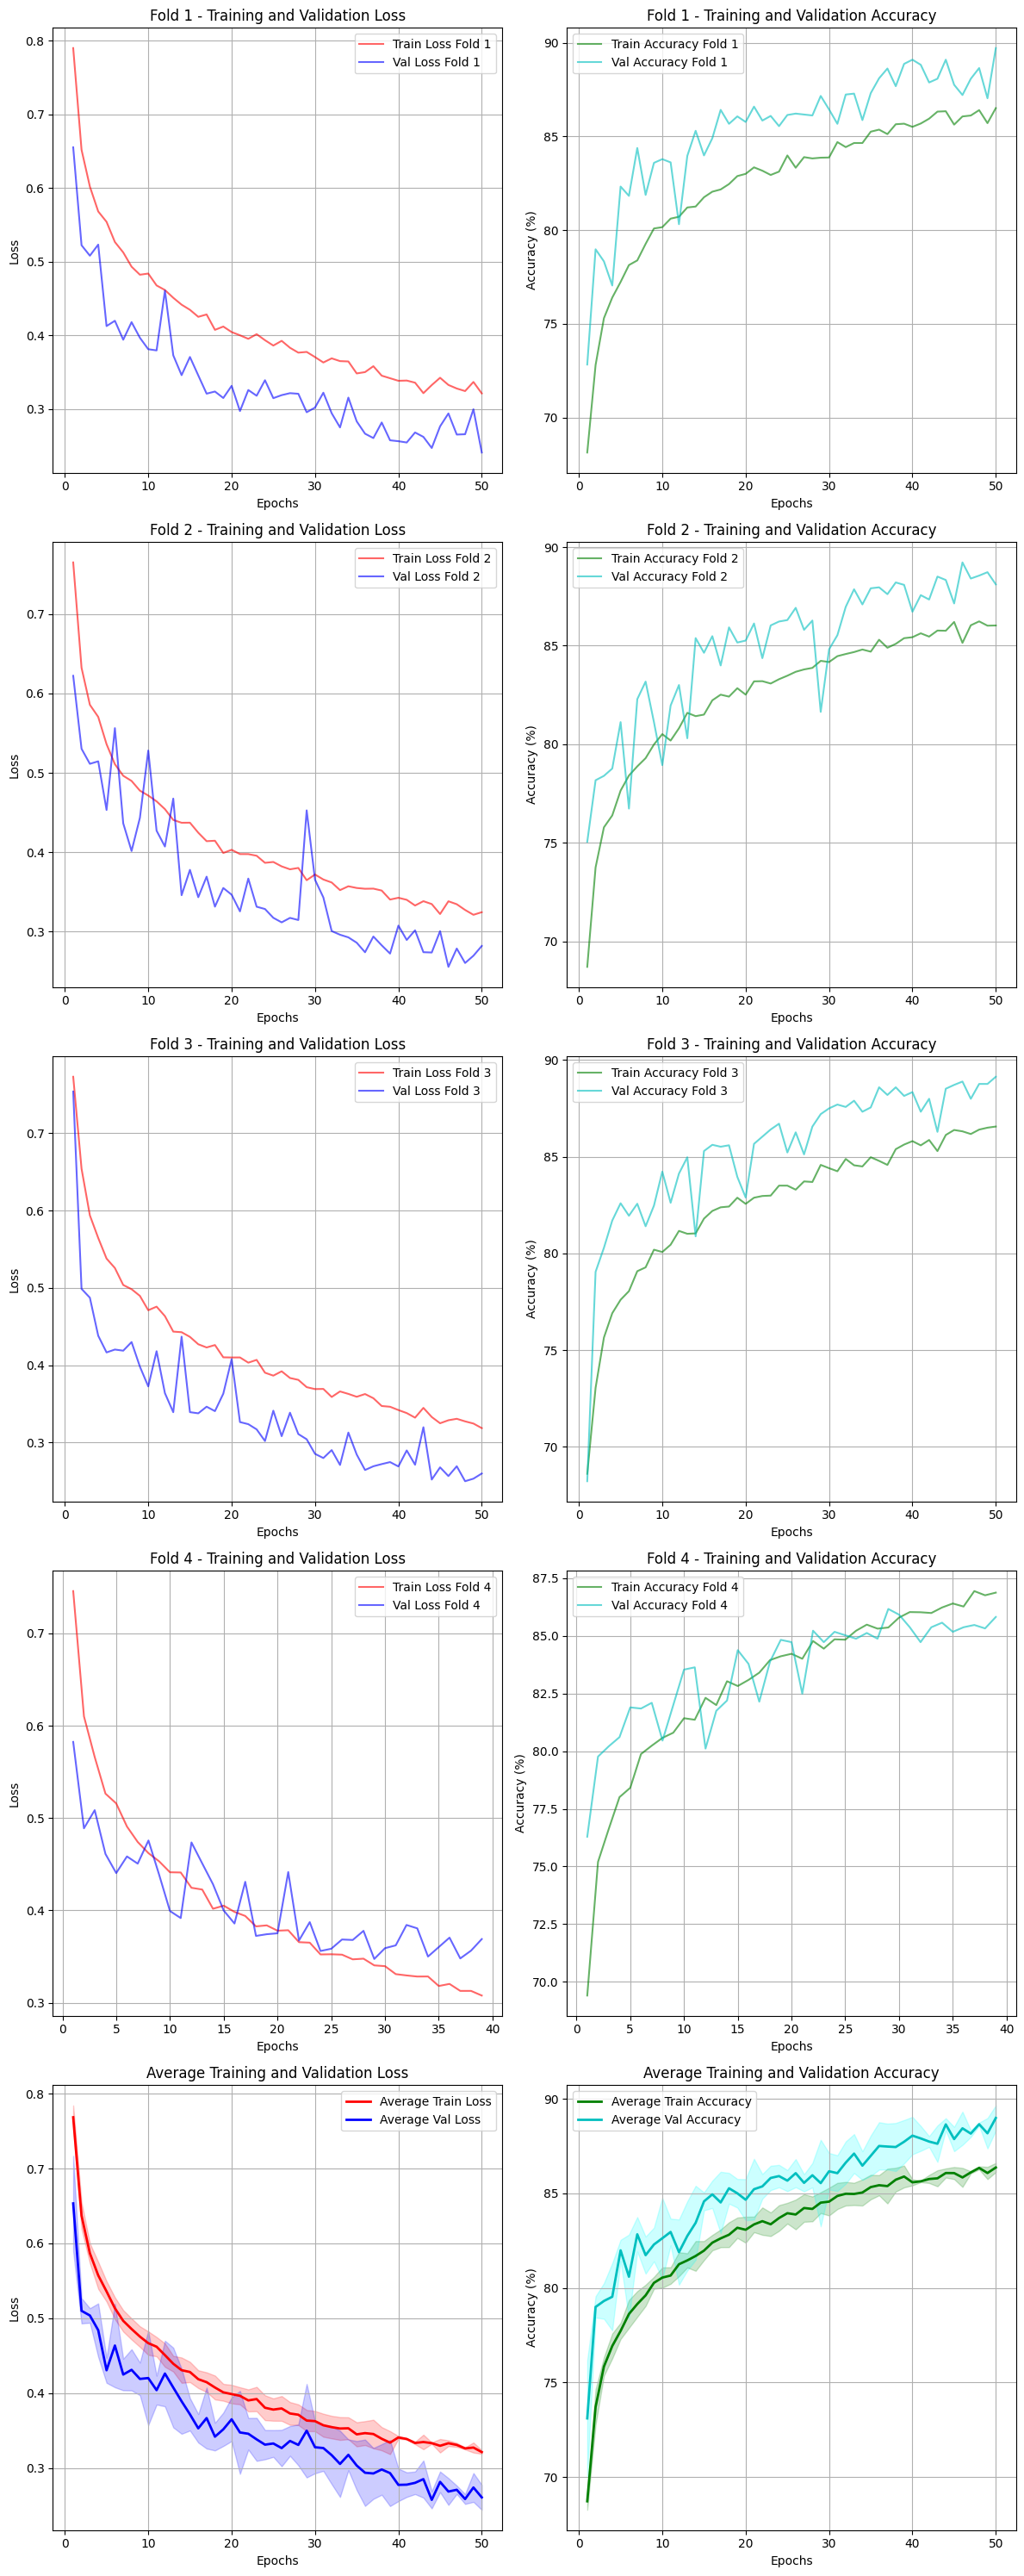

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_and_average(fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies):
    # Find the maximum number of epochs across all folds
    max_epochs = max(len(fold) for fold in fold_train_losses)
    epochs = range(1, max_epochs + 1)
    num_folds = len(fold_train_losses)

    # Create a figure with separate subplots for each fold and two additional for averages
    fig, axes = plt.subplots(num_folds + 1, 2, figsize=(12, 6 * (num_folds + 1)))

    for fold in range(num_folds):
        # Pad or truncate the lists for each fold
        train_loss = fold_train_losses[fold][:max_epochs] + [np.nan] * (max_epochs - len(fold_train_losses[fold]))
        val_loss = fold_val_losses[fold][:max_epochs] + [np.nan] * (max_epochs - len(fold_val_losses[fold]))
        train_accuracy = fold_train_accuracies[fold][:max_epochs] + [np.nan] * (max_epochs - len(fold_train_accuracies[fold]))
        val_accuracy = fold_val_accuracies[fold][:max_epochs] + [np.nan] * (max_epochs - len(fold_val_accuracies[fold]))

        # Plot loss for each fold
        ax_loss = axes[fold, 0]
        ax_loss.plot(epochs, train_loss, 'r-', alpha=0.6, label=f'Train Loss Fold {fold+1}')
        ax_loss.plot(epochs, val_loss, 'b-', alpha=0.6, label=f'Val Loss Fold {fold+1}')
        ax_loss.set_title(f'Fold {fold+1} - Training and Validation Loss')
        ax_loss.set_xlabel('Epochs')
        ax_loss.set_ylabel('Loss')
        ax_loss.legend()
        ax_loss.grid()

        # Plot accuracy for each fold
        ax_acc = axes[fold, 1]
        ax_acc.plot(epochs, train_accuracy, 'g-', alpha=0.6, label=f'Train Accuracy Fold {fold+1}')
        ax_acc.plot(epochs, val_accuracy, 'c-', alpha=0.6, label=f'Val Accuracy Fold {fold+1}')
        ax_acc.set_title(f'Fold {fold+1} - Training and Validation Accuracy')
        ax_acc.set_xlabel('Epochs')
        ax_acc.set_ylabel('Accuracy (%)')
        ax_acc.legend()
        ax_acc.grid()

    # Plot average loss for all folds
    avg_train_losses = np.nanmean([fold[:max_epochs] + [np.nan] * (max_epochs - len(fold)) for fold in fold_train_losses], axis=0)
    avg_val_losses = np.nanmean([fold[:max_epochs] + [np.nan] * (max_epochs - len(fold)) for fold in fold_val_losses], axis=0)
    std_train_losses = np.nanstd([fold[:max_epochs] + [np.nan] * (max_epochs - len(fold)) for fold in fold_train_losses], axis=0)
    std_val_losses = np.nanstd([fold[:max_epochs] + [np.nan] * (max_epochs - len(fold)) for fold in fold_val_losses], axis=0)

    ax_loss_avg = axes[num_folds, 0]
    ax_loss_avg.plot(epochs, avg_train_losses, 'r-', label='Average Train Loss', linewidth=2)
    ax_loss_avg.plot(epochs, avg_val_losses, 'b-', label='Average Val Loss', linewidth=2)
    ax_loss_avg.fill_between(epochs, avg_train_losses - std_train_losses, avg_train_losses + std_train_losses, color='red', alpha=0.2)
    ax_loss_avg.fill_between(epochs, avg_val_losses - std_val_losses, avg_val_losses + std_val_losses, color='blue', alpha=0.2)
    ax_loss_avg.set_title('Average Training and Validation Loss')
    ax_loss_avg.set_xlabel('Epochs')
    ax_loss_avg.set_ylabel('Loss')
    ax_loss_avg.legend()
    ax_loss_avg.grid()

    # Plot average accuracy for all folds
    avg_train_accuracies = np.nanmean([fold[:max_epochs] + [np.nan] * (max_epochs - len(fold)) for fold in fold_train_accuracies], axis=0)
    avg_val_accuracies = np.nanmean([fold[:max_epochs] + [np.nan] * (max_epochs - len(fold)) for fold in fold_val_accuracies], axis=0)
    std_train_accuracies = np.nanstd([fold[:max_epochs] + [np.nan] * (max_epochs - len(fold)) for fold in fold_train_accuracies], axis=0)
    std_val_accuracies = np.nanstd([fold[:max_epochs] + [np.nan] * (max_epochs - len(fold)) for fold in fold_val_accuracies], axis=0)

    ax_acc_avg = axes[num_folds, 1]
    ax_acc_avg.plot(epochs, avg_train_accuracies, 'g-', label='Average Train Accuracy', linewidth=2)
    ax_acc_avg.plot(epochs, avg_val_accuracies, 'c-', label='Average Val Accuracy', linewidth=2)
    ax_acc_avg.fill_between(epochs, avg_train_accuracies - std_train_accuracies, avg_train_accuracies + std_train_accuracies, color='green', alpha=0.2)
    ax_acc_avg.fill_between(epochs, avg_val_accuracies - std_val_accuracies, avg_val_accuracies + std_val_accuracies, color='cyan', alpha=0.2)
    ax_acc_avg.set_title('Average Training and Validation Accuracy')
    ax_acc_avg.set_xlabel('Epochs')
    ax_acc_avg.set_ylabel('Accuracy (%)')
    ax_acc_avg.legend()
    ax_acc_avg.grid()

    plt.tight_layout()
    plt.show()

# Usage:
plot_all_and_average(fold_train_losses, fold_val_losses, fold_train_accuracies, fold_val_accuracies)


### Testing


Evaluating on the test set...
Test Loss: 0.3563, Test Accuracy: 85.88%

Classification Report:
                      precision    recall  f1-score   support

 Bacterial Pneumonia     0.7414    0.7469    0.7441       403
Corona Virus Disease     0.9744    0.9361    0.9549       407
              Normal     0.8981    0.9604    0.9282       404
        Tuberculosis     0.9752    0.9632    0.9692       408
     Viral Pneumonia     0.7023    0.6849    0.6935       403

            accuracy                         0.8588      2025
           macro avg     0.8583    0.8583    0.8580      2025
        weighted avg     0.8588    0.8588    0.8585      2025


Confusion Matrix:


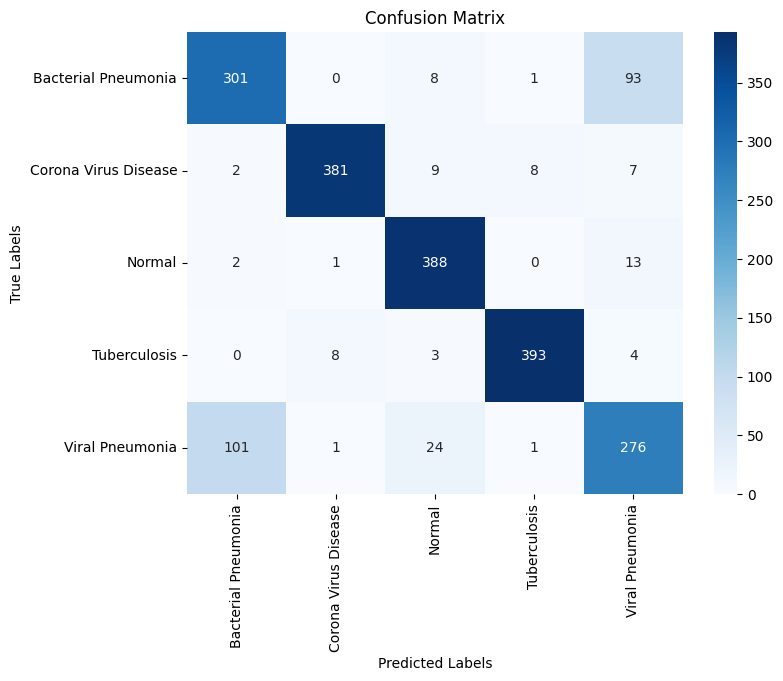

In [11]:
# Test the model
test_dataset = datasets.ImageFolder(test_dir, transform=valid_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
def test_model(model, test_loader, criterion, class_names):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            # Predictions and accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect true and predicted labels
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate accuracy and average loss
    test_acc = 100 * correct / total
    avg_loss = total_loss / len(test_loader)

    # Print metrics
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {test_acc:.2f}%\n")

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # Confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Example usage:
# Assuming your dataset has 'classes' attribute
class_names = test_loader.dataset.classes

# Now that cross-validation is complete, evaluate on the test set using the best model
print("\nEvaluating on the test set...")
test_model(model, test_loader, criterion, class_names)